# Hypothesis test
This notebook was written by Yubo Wang. It contains jupyter notebook code for hypothesis test over the historical data and the two distributions to see if they are different significantly.
## General Question:
After collecting all the historical records, we want to examine if the historical records and the hypothesized distribution which win rate of state tournament is the ratio between school population and the total population within the division. Alo we want to see if the empirical distribution fits the historical records or not.
## Our Approach:
We simulate the probability of being into the top 16 based on the hypothesis that the win rate of state tournament is the ratio between school population and the total population within the division. Then we use the proportion test on the data as we believe the event of being into top 16. Then, because the data size for a sigle school is too small for the hypothesis testing, so we combine some school with similar population size and use their average probability of being into top 16 and average population size to calculate the result. Then we generate the probability of each school being into the top 16 by the beta modeal that introduced in the previous research and then use the same process of hypothesis testing.

In [1]:
import pandas as pd
from scipy.stats import t, chisquare, norm
import matplotlib.pyplot as plt
import numpy as np

### DataFrames:
#### school information (501$\times$4)
df_all
* ID (int): unique school ID number
* Name (str): school name
* pop (int): number of girl students in school
* div (str): I, II, or III depending on size
#### simulation result of the probability of each school being into the top 16 in state tournament by using the beta model (167$\times$5)
df_all2
* ID (int): unique school ID number
* mean (float): the result of the probability of each school being into the top 16 in state tournament by using the beta model
* pop (int): number of girl students in school
#### result of running competition of division 1 (347$\times$4)
df1
* school (str): school name
* year (int): year of competition
* school ID (int): unique school ID number
* pop (int): number of girl students in school

In [2]:
df_all = pd.read_csv(r"allxc.csv")
df_all["pop"] = df_all["pop"].apply(lambda x: int(x))
df_all = df_all.loc[:, "ID": "div"]

df_all2 = pd.read_csv(r"empirical_distribution16.csv")

df1 = pd.read_csv(r"div1.csv")
df1 = df1[df1["pop"].notna()]
df1["place"] = df1["place"].apply(lambda x: x.replace("*", ""))
df1["place"] = df1["place"].apply(lambda x: int(x))
df1["pop"] = df1["pop"].apply(lambda x: int(x))
df1.pop("place")
df1.pop("score")
df1 = df1[df1["school ID"].isin(df_all["ID"].values)]

total_num_schools = 167

## Calculation:
### Introduction:
In this part, we combine schools with similar population (the school with index inrange beween *start* and *end*) and then use the hypothesis testing to test the result.
### Concept:
In this part, we use the proportional test over the events with the formula:

$$t-score = \frac{p_1-p_0}{\sqrt{p(1-p)\frac{2}{n}}}$$
$$p_0 = \text{probability of being into the top 16 according to the distribution}$$
$$p_1 = \frac{\text{actual times that those schools to get into the top 16}}{\text{total number of chances fort hose schools to get into the top 16}}$$
$$p = \frac{p_1+p_0}{2}$$

Then we are able to calculate the p-value from t-score and plot the graph to see that the difference.
### Variables:
* temp_df (DataFrame): a DataFrame sliced from the df1 which includes the schools with the population in the given range
* temp_all (DataFrame): a DataFrame sliced from the df_all which includes the schools with the population in the given range
* num_of_school (int): how many distince schools in the historical data
* total (Series): a Series sliced from the df-all which includes the populations of schools in division 1
* total_pop (int): a sum population of schools in division 1
* total_count (int): total number of schools in the division
* count (int): total number of samples in the hypothesis test
* p_0 (float): hypothesized probabilidy
* p (float): probability that we calculate from historical records
* ts (float): t-score

In [3]:
def get_result_between_pop(df, df_all, df_num, start, end):
    """
    This function calculate the p-value and t-score of win rate for some schools with population between start and end (inclusive)
    params:
        df: a dataframe include schools that are in top 16 in each year
        df_all: a dataframem include all schools with their ID and population
        df_num: a string of which division are the schools in
        start: index of start of range of index of schools (inclusive)
        end: index of end of range of index of schools (exclusive)
    return:
        p: success rate in proportional test based on historical data
        p_0: success rate in proportional test based on the hypothesis
        ts: t-score in proportional test which descrive how difference the historical data is from the hypothesis
        num_of_school: how many distince schools in the historical data
        avg_pop: average population of the schools we choose
    """
    
    # choose the schools that have the population size in the range
    chosen_schools = df_all[df_all["div"] == df_num].reset_index()[["ID", "pop"]].sort_values("pop").iloc[start:end]
    historical = df[df["school ID"].isin(chosen_schools["ID"])]

    if len(chosen_schools) == 0:
        return None
    
    avg_pop = chosen_schools["pop"].mean()
    num_of_schools = len(chosen_schools)
    historical_freq = len(historical)
    p_0 = avg_pop * 0.000128101995073
    p_1 = historical_freq / (21 * num_of_schools)
    p = (p_0 + p_1)/2
    ts = (p_1 - p_0) / ((p * (1 - p) * (2/(21*3))) ** 0.5)
    
    return p_1, p_0, ts, num_of_schools, avg_pop, chosen_schools["ID"]

## Graphs:
### Introduction:
We want to visualize the result from previous part so we run the function to do the hypothesis testing on all the schools and then plot the results of p-value, t-score and number of schools vs. population
### Variables:
* p_val_list: a list of p-value
* prob_list: a list of probability that calculated from historical records
* prob_0_list: a list of hypothesized probability
* pop_list: a list of population
* num_of_school: a list of number of schools that are in the give population range
* ts_list: a list of t-score
### Graphs:
* graph 1: the graph plot the p-value vs. population, and the green line shows the 0.05 range of p-value and the orange line shows the average p-value of all the data
* graph 2: the graph plot the number of schools in each population range to give a general view of how many schools in each test
* graph 3: the graph plot the t-score vs. population, it also shows the information about the probability in historical records is larger or smaller than the hypothesized probability
* graph 4: the graph plt the probability of being into top 16 from both historical records and hypo probability vs. population shows the trend of historical data and the hypothesis win rate to provide a general view of those data

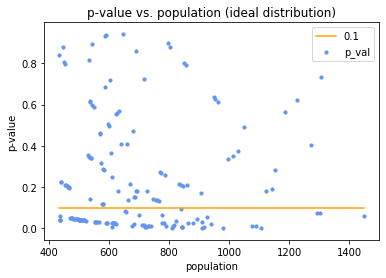

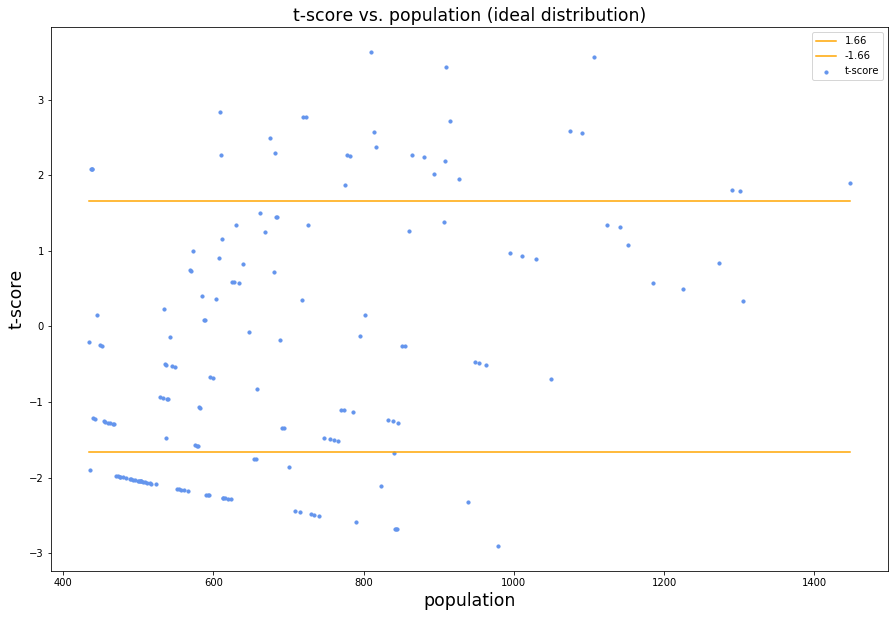

In [4]:
p_val_list = []
prob_list = []
prob_0_list = []
pop_list = []
# num_of_school = []
ts_list = []
# school_ID = []

for i in range(0, total_num_schools-2):
    ret = get_result_between_pop(df1, df_all, "I", i, i+3)
    if ret:
        p, p_0, ts, num_of_schools, avg_pop, ids = ret
        if num_of_schools >= 1:
            prob_list.append(p)
            prob_0_list.append(p_0)
            p_val_list.append(t.sf(abs(ts), 21*3*2-1)*2)
            pop_list.append(avg_pop)
            # num_of_school.append(num_of_schools)
            ts_list.append(ts)
            # school_ID.append(ids)

avg = sum(p_val_list) / len(p_val_list)
plt.scatter(pop_list, p_val_list, color="cornflowerblue", label="p_val", s=10)
l2, = plt.plot([pop_list[0], pop_list[-1]], [0.1, 0.1], color="orange", label="0.1")
plt.xlabel("population")
plt.ylabel("p-value")
plt.title("p-value vs. population (ideal distribution)")
plt.legend(scatterpoints=1, loc = 'best')
plt.savefig('p-value', transparent=True)
plt.show()

plt.scatter(pop_list, ts_list, color="cornflowerblue", label="t-score", s=10)
plt.plot([pop_list[0], pop_list[-1]], [1.66, 1.66], color="orange", label="1.66")
plt.plot([pop_list[0], pop_list[-1]], [-1.66, -1.66], color="orange", label="-1.66")
plt.xlabel("population")
plt.ylabel("t-score")
plt.title("t-score vs. population (ideal distribution)")
plt.legend(scatterpoints=1, loc = 'best')
plt.savefig('t_score', transparent=True)
plt.show()

Then we use the list of p-values to see how many points are there have the p-value < 0.1

In [5]:
print(sum([int(i<0.1) for i in p_val_list]) / len(p_val_list))

0.47878787878787876


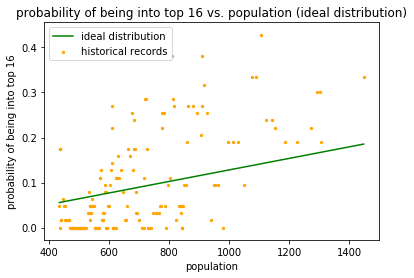

In [6]:
plt.scatter(pop_list, prob_list, label="historical records", c="orange", s=5)
plt.plot(pop_list, prob_0_list, label="ideal distribution", c="green")
plt.legend()
plt.title("probability of being into top 16 vs. population (ideal distribution)")
plt.xlabel("population")
plt.ylabel("probability of being into top 16")
plt.savefig('prob - real.png', transparent=True)
plt.show()

In [7]:
def get_result_between_pop2(df, df_all, df_num, start, end):
    """
    This function calculate the p-value and t-score of win rate for some schools with population between start and end (inclusive)
    params:
        df: a dataframe include schools that are in top 16 in each year
        df_all: a dataframem include all schools with their ID and population
        df_num: a string of which division are the schools in
        start: index of start of range of index of schools (inclusive)
        end: index of end of range of index of schools (exclusive)
    return:
        p: success rate in Poisson binomial test based on historical data
        p_0: success rate in Poisson binomial test based on the hypothesis
        ts: t-score in Poisson binomial test which descrive how difference the historical data is from the hypothesis
        num_of_school: how many distince schools in the historical data
        avg_pop: average population of the schools we choose
    """
    # choose the schools that have the population size in the range
    chosen_schools = df_all.reset_index()[["ID", "pop", "prob"]].sort_values("pop").iloc[start:end]
    historical = df[df["school ID"].isin(chosen_schools["ID"])]

    # print(chosen_schools)

    if len(chosen_schools) == 0:
        return None
    
    num_of_schools = len(chosen_schools)
    historical_freq = len(historical)
    # p_0 = chosen_schools["mean"].mean()
    p_0 = chosen_schools["prob"].mean()
    p_1 = historical_freq / (21 * num_of_schools)
    p = (p_0 + p_1) / 2
    ts = (p_1 - p_0) / ((p * (1 - p) * (2/(21*3))) ** 0.5)
    
    return p_1, p_0, ts, num_of_schools, chosen_schools["pop"].mean(), chosen_schools["ID"]

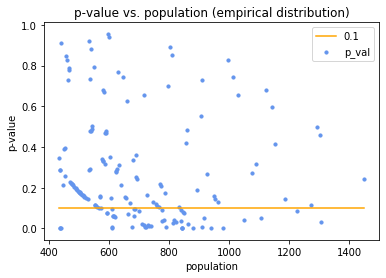

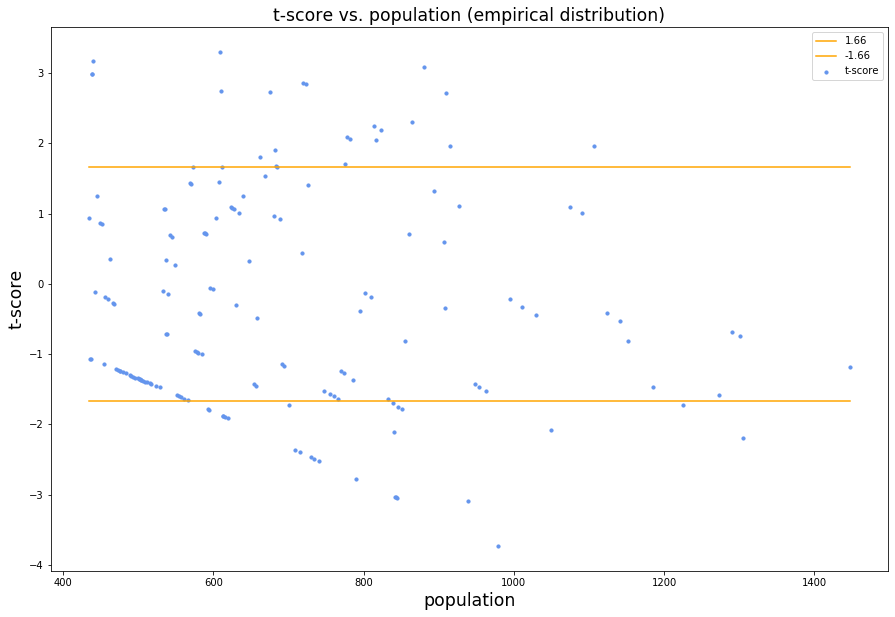

In [8]:
p_val_list2 = []
prob_list2 = []
prob_0_list2 = []
pop_list2 = []
# num_of_school2 = []
ts_list2 = []
# school_ID2 = []

for i in range(0, total_num_schools-2):
    ret = get_result_between_pop2(df1, df_all2, "I", i, i+3)
    if ret:
        p, p_0, ts, num_of_schools, avg_pop, ids = ret
        if num_of_schools >= 1:
            prob_list2.append(p)
            prob_0_list2.append(p_0)
            p_val_list2.append(t.sf(abs(ts), 21*3*2-1)*2)
            # p_val_list2.append(norm.sf(abs(ts)))
            pop_list2.append(avg_pop)
            # num_of_school2.append(num_of_schools)
            ts_list2.append(ts)
            # school_ID2.append(ids)

        # break

avg = sum(p_val_list) / len(p_val_list)
plt.scatter(pop_list2, p_val_list2, color="cornflowerblue", label="p_val", s=10)
l2, = plt.plot([pop_list2[0], pop_list2[-1]], [0.1, 0.1], color="orange", label="0.1")
plt.xlabel("population")
plt.ylabel("p-value")
plt.title("p-value vs. population (empirical distribution)")
plt.legend(scatterpoints=1, loc = 'best')
plt.savefig('p-value2', transparent=True)
plt.show()

plt.scatter(pop_list2, ts_list2, color="cornflowerblue", label="t-score", s=10)
plt.plot([pop_list2[0], pop_list2[-1]], [1.66, 1.66], color="orange", label="1.66")
plt.plot([pop_list2[0], pop_list2[-1]], [-1.66, -1.66], color="orange", label="-1.66")
plt.xlabel("population")
plt.ylabel("t-score")
plt.title("t-score vs. population (empirical distribution)")
plt.legend(scatterpoints=1, loc = 'best')
plt.savefig('t_score2', transparent=True)
plt.show()

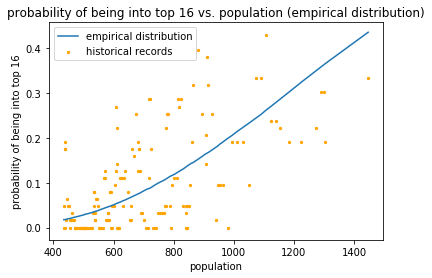

In [9]:
plt.scatter(pop_list2, prob_list2, label="historical records", c="orange", s=5)
plt.plot(pop_list2, prob_0_list2, label="empirical distribution")
plt.legend()
plt.title("probability of being into top 16 vs. population (empirical distribution)")
plt.xlabel("population")
plt.ylabel("probability of being into top 16")
plt.savefig('prob - real2', transparent=True)
plt.show()

In [10]:
print(sum([int(i<0.1) for i in p_val_list2]) / len(p_val_list2))

0.30303030303030304


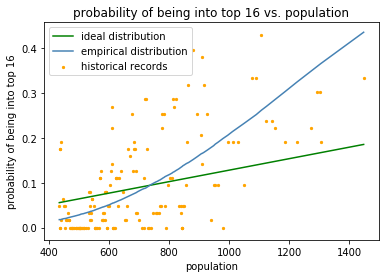

In [11]:
plt.scatter(pop_list2, prob_list2, label="historical records", c="orange", s=5)
plt.plot(pop_list, prob_0_list, label="ideal distribution", c="green")
plt.plot(pop_list2, prob_0_list2, label="empirical distribution", c="steelblue")
plt.legend()
plt.title("probability of being into top 16 vs. population")
plt.xlabel("population")
plt.ylabel("probability of being into top 16")
plt.savefig('prob - real3', transparent=True)
plt.show()